Задача по извлечению фич из ЭМГ.
Основная статья
https://www.researchgate.net/publication/325226027_Feature_Extraction_and_Selection_for_Myoelectric_Control_Based_on_Wearable_EMG_Sensors

1. Фичи, харктеризующие мощность и амплитуду сигнала

    Integrated Absolute Value IAV
    
    Mean Absolute Value MAV
    
    Root Mean Square RMS
    
    Variance VAR
    
    Waveform Length WL
    
    Log Detector LD
    
    Difference Absolute Mean Value DAMV
    
    Differebce Absolute Standard Deviation Value DASDV
    
    Differebce Variance Value DVARV
    
    Mean Value of Square Root MSR
    
    L-scale LS 

2. Фичи, характеризующие нелинейность и частотную информацию

    Maximum Fractal Length MFL
    
    https://www.mdpi.com/2079-3197/7/1/12/htm
    
    Detrended fluctuation analysis DFA
    
    Sample Entropy SampEn
    
    Zero Crossing ZC
    
    Slope Sign Change SSC
    
    Willison Amplitude WAMP
    
    Median Frequency MDF
    
    Mean Frequency MNF
    
3. Фичи, использующие ЭМГ как временные ряды

    Autoregressive Coefficients AR
    
    Cepstrum Coefficients CC
    
    Разного порядка 4 6 9
   
4. Уникальные

    HIST - расширение ZC и WAMP 9 data bins
    
Предложенные группы фичей
1. MAV WL ZC SSC
2. RMS AR6
3. MAV WL ZC SSC RMS AR6
4. AR4 HIST9
5. WL LD SSC AR9
6. WL SSC AR9 CC9
7. RMS VAR LD HIST9
8. WL RMS SampEn CC4


Частота сэмплов 200 Гц и 1000 Гц
SVM linear kernel

Выводы
Для данных с разной частотой производительность фич отличается.
Хорошо работают фичи первой группы. 
Фичи третьей группы лучше для частоты 1000 Гц

Датасеты ninaPro

1. 52 движения, 27 человек. Нужны столбцы 12 emg, stimulus (что пытались повторить), restimulus(что в итоге повторили). Otto Bock. Повторение движения 10 раз. 100 Гц

2. 40 человек, Delsys, 49 движений, повторение 6 раз 2000 Гц
3. То же, что и 2, но 11 инвалидов 2000 Гц

4. Cometa 10 человек 2000 Гц
5. Myo 10 человек 200 Гц

6. 10 человек в течение 5 дней. Delsys Для изучения воспроизводимости 2000 Гц

7. 20 человек 2 инвалида 40 классов Delsys 2000 Гц

In [2]:
#Загрузим несколько файлов датасета
import scipy.io
data1 = scipy.io.loadmat('s1/S1_E1_A1.mat')
#data2 = scipy.io.loadmat('DB2_s4/S4_E2_A1.mat')
#data3 = scipy.io.loadmat('DB2_s4/S4_E3_A1.mat')

#Файлы E1 E2 E3 - классы упражнений
#E1 - разные жесты из серии камень/ножницы/бумага
#E2 - разные хватания: бутылки, карандаша и тп
#E3 - более мелкие движения типа печатания на клавиатуре

In [1]:
import numpy as np

In [2]:
def from_mat_to_numpy(data):
    """
    Функция для формирования датасета в виде, который можно скормить классификатору.
    
    data - словарь, полученный в результате чтения .mat файла. Ключи в нём - названия, значения - значения в виде numpy массивов.
    Интересующие нас:
        emg - сигнал
        stimulus - номер выполняемого движения
        repetition - номер повтора движения
        
    Сигнал, соотв. одному и тому же повторению и движению, склеиваем в один. И сопоставляем соотв.номер движения и повторения.
    Пропускаем моменты отдыха (движение 0).
    И ещё обрезаем до одинаковой длины 5с или 12*10000 значений.
    """
    #Длина желаемой ЭМГ в секундах
    EMG_LEN = 5
    #Частота записи ЭМГ в Гц
    EMG_RATE = 2000
    #Количество каналов при записи
    EMG_CHANNELS = 12
    emg = data['emg']
    target = data['stimulus']
    repetition = data['repetition']
    
    n = emg.shape[0]
    
    curr_target = 0
    curr_rep = 0
    current_emg = np.array([])
    preprocess_data = np.zeros(shape=(17*6, EMG_LEN*EMG_RATE*EMG_CHANNELS + 2))
    index = 0
    for i in range(n):
        if target[i][0] == curr_target and repetition[i][0] == curr_rep:
            if curr_target != 0 and curr_rep != 0:
                current_emg = np.append(current_emg, emg[i])
        else:
            if curr_target != 0 and curr_rep != 0:
                diff = current_emg.shape[0] - EMG_RATE*EMG_LEN*EMG_CHANNELS
                if diff > 0:
                    begin = diff//2   
                    end = current_emg.shape[0] - diff + begin
                current_emg = current_emg[begin:end]    
                current_emg = np.append(current_emg, curr_target)
                current_emg = np.append(current_emg, curr_rep)
                preprocess_data[index] = current_emg
                index += 1
            curr_target = target[i][0]
            curr_rep = repetition[i][0]
            current_emg = emg[i]
    return preprocess_data

In [ ]:
"""
Сделать обучение, выделяя фичи из рандомных окон в 100 мс, посмотреть, что будет получаться.
Для различных n.
Для различных наборов фичей
Для 1000 и 2000

1. Реализовать одну группу фичей
2. Реализовать рандомное выделение фичей в зав. от n
3. Поделить на трэйн-тест. Выделять фичи в зав. от n для трэйна и теста. Обучиться, запомнить результат.
4. Построить график
"""

In [8]:
import numpy as np

In [36]:
#Скрипт для обработки данных
#Проходимся по папкам с датасетом, открываем файлы, обрабатываем в нужный вид и сохраняем все npy.
def process_mat_files(path):
    file_name = "/DB2_s{n:d}/S{n:d}_E1_A1.mat"
    #processed_file_name = "/processed/S{n:d}_E1_A1"
    file_path = path + file_name
    processed_files = from_mat_to_numpy(scipy.io.loadmat(file_path.format(n=1)))
    for i in range(2, 41):
        current_file_path = file_path.format(n=i)
        current_file = scipy.io.loadmat(current_file_path)
        processed_files = np.concatenate((processed_files, from_mat_to_numpy(current_file)), axis=0)
        print(i)
    np.save(path + '/dataset', processed_files)

In [37]:
process_mat_files("data/ninaPro/DB2")

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [2]:
from scipy import signal

In [3]:
#Реализация фильтров для ЭМГ
def notch(data, val = 50, fs = 2000):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin
    
def bandpass(data, start = 5, stop = 999, fs = 2000):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(5, bp_Hz / (fs / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

In [4]:
#Реализация фичей
def integrated_absolute_value(segment):
    """
    Функция вычисления фичи IAV для конкретного сегмента.
    Площадь под кривой ЭМГ (мощность)
    """
    return sum([abs(s) for s in segment])

def mean_absolute_value(segment):
    """
    Функция вычисления фичи MAV для конкретного сегмента.
    Среднее значение сигнала по модулю.
    """
    return sum([abs(s) for s in segment])/len(segment)

def waveform_length(segment):
    """
    Функция вычисления фичи WL для конкретного сегмента.
    Суммарная длина сигнала. Сумма разностей соседних значений.
    """
    n = len(segment)
    wl = 0
    for i in range(1, n):
        wl += abs(segment[i] - segment[i-1])
    return wl

def zero_crossing(segment):
    """
    Функция вычисления фичи ZC для конкретного сегмента.
    Количество раз, когда сигнал пересекает ноль. Частотная информация.
    """
    #Можно задать e - погрешность на шумы и добавить условие |x_k - x_(k+1)| >= e.
    n = len(segment)
    zc = 0
    for i in range(n - 1):
        if segment[i] * segment[i+1] < 0:
            zc += 1
    return zc

def slope_sign_changes(segment):
    """
    Функция вычисления фичи SSC для конкретного сегмента. 
    Количество раз, когда сигнал меняет возрастание/убывание.
    Как и ZC выделяет частотную информацию. 
    """
    n = len(segment)
    ssc = 0
    for i in range(1, n-1):
        if segment[i-1] < segment[i] and segment[i] > segment[i+1] or segment[i-1] > segment[i] and segment[i] < segment[i+1]:
            ssc += 1
    return ssc

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
class random_feature_exctraction:
    """
    Класс для извлечения фичей из ЭМГ.
    Fields: 
        rate - частота ЭМГ в Гц, 
        window_size - ширина окна, по которому вычисляется фича, в мс
        n_channels - количество каналов ЭМГ
        window_begin - индекс начала окна
        features_list - список фичей, которые хотим извлечь
    """
    def __init__(self, rate, window_size, n_channels, window_begin, features_list):
        self.rate = rate
        self.window_len = int(self.rate/1000*window_size)  # Соотв. длина окна для одного канала
        self.n_channels = n_channels
        self.features_list = features_list
        self.window_begin = window_begin
    
    def exctract(self, emg):
        """
        Извлекает фичи из features_list для каждого канала из окна размера window_size с началом window_begin.
        Parameters:
            emg - numpy array of size (number_of_samples, length_of_signal)
            One row of emg:
             channel_1_value_1 channel_2_value_1 ... channel_m_value_1 channel_1value_2 ...
        Return:
            numpy array with new features
            Each row of emg is processed:
             channel_1_feature_1 channel_1_feature2 ... channel_1_feature_n channel_2_feature_1 .... channel_m_feature_n

        """
        number_of_samples, signal_len = emg.shape
        X = [[] for _ in range(number_of_samples)]
        for j in range(number_of_samples):
            feature_vector = []
            #Для каждого канала
            for channel in range(self.n_channels):
                step = self.n_channels
                #Выделяем значения одного канала с учетом желаемой частоты
                channel_emg = emg[j][channel::step]
                # Для сегмента [window_begin:window_begin+window_len] вычисляем значения фичей и записываем их в вектор
                begin = self.window_begin
                end = begin + self.window_len
                segment = channel_emg[begin:end]
                for f in self.features_list:
                    feature_vector.append(f(segment))
            X[j] = feature_vector
        return np.array(X)

In [9]:
#Загрузим весь датасет
data = np.load('data/ninaPro/DB2/dataset.npy')
print(data.shape)

(4080, 120002)


In [10]:
#Возьмем пока 7 классов 1..7
n, m = data.shape
idx_to_del = []
classes = [1, 2, 3, 4, 5, 6, 7]
for i in range(n):
    if (data[i][120000] not in classes):
        idx_to_del.append(i)
data = np.delete(data, idx_to_del, axis=0)
print(data.shape)

(1680, 120002)


In [53]:
def filter_emg(X):
    #Для каждого повторения и класса применяем фильтр
    n, m = X.shape
    for i in range(n):
        X_filtered = X[i]
        X_filtered = np.reshape(X_filtered, (m//12, 12))
        X_filtered = np.apply_along_axis(notch, 0, X_filtered)
        X_filtered = np.apply_along_axis(bandpass, 0, X_filtered)
        X_filtered = np.reshape(X_filtered, (1, m))
        X[i] = X_filtered

In [12]:
import random
random.seed(42)

In [65]:
#Извлекаем фичи и сохраняем файлы для n=10, 20, ..., N
def exctract_and_save(emg, features_list, feature_set_num, N=100, n_step=1, window_size=100, rate=2000, emg_len=5000, n_channels=12):
    max_idx = rate / 1000 * (emg_len - window_size)
    X_features = np.array([[] for _ in range(emg.shape[0])])
    filename = 'data/ninaPro/DB2/featureSet{fs_num:d}/X_{i:d}_{rate:d}'
    for i in range(1, N+1):
        n = random.randint(0, max_idx-1)
        extractor = random_feature_exctraction(
            rate=rate, 
            window_size=window_size, 
            n_channels=n_channels, 
            window_begin=n, 
            features_list=features_list)
        X_features = np.concatenate((X_features, extractor.exctract(emg)), axis=1)
        if (i%n_step == 0):
            np.save(filename.format(fs_num=feature_set_num, i=i, rate=rate), X_features)
        print(i)

In [50]:
n = data.shape[1]
X_2000 = data[:, :n-2]
y = data[:, n-2]

In [51]:
X_1000 = data[:, 0:n-2:2]
print(X_1000.shape)

(1680, 60000)


In [54]:
filter_emg(X_2000)

In [55]:
filter_emg(X_1000)

In [66]:
featureSet1 = [mean_absolute_value, waveform_length, zero_crossing, slope_sign_changes]
exctract_and_save(emg=X_2000, features_list=featureSet1, feature_set_num=1, n_step=5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [70]:
exctract_and_save(X_1000, featureSet1, 1, rate=1000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [14]:
#Зафиксируем количество классов
N_CLASSES = 7

In [21]:
#Разделим таргет на train/test. В тест запишем каждое 6 повторение
n = y.shape[0]
test_idx = range(5, n, 6)
y_train = np.delete(y, test_idx, axis=0)
y_test = y[test_idx]

In [22]:
print(y_train.shape)
print(y_test.shape)

(1400,)
(280,)


In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [24]:
y_train = keras.utils.to_categorical(y_train - 1, num_classes=N_CLASSES)
y_test = keras.utils.to_categorical(y_test - 1, num_classes=N_CLASSES)

In [25]:
print(y_train.shape)
print(y_test.shape)

(1400, 7)
(280, 7)


In [67]:
def experiment(n, feature_set_num, rate):
    #Загружаем данные, соотв. n - количество извлечений фич из окон по 100 мс
    X = np.load('data/ninaPro/DB2/featureSet{num:d}/X_{n:d}_{r:d}.npy'.format(num=feature_set_num, n=n, r=rate))
    #Разобьем на train и test признаки аналогично таргету
    X_train = np.delete(X, test_idx, axis=0)
    X_test = X[test_idx][:]
    #Масштабируем фичи
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Создание модели
    dim = X_train.shape[1]
    model = Sequential()
    model.add(Dense(36, activation='relu', input_dim=dim))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #Обучение модели
    model.fit(X_train, y_train, epochs=150, batch_size=50)
    test_size = X_test.shape[0]
    score = model.evaluate(X_test, y_test, batch_size=test_size)
    
    #Возвращаем итоговую метрику на тесте
    return score[1]

In [71]:
#Создадим массивы для построения графиков
def arrays_for_plot(feature_set_n, rate):
    n_windows = list(range(5, 101, 5))
    metrics = []
    for n in n_windows:
        acc = experiment(n, feature_set_n, rate=rate)
        metrics.append(acc)
    return n_windows, metrics

In [31]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\novon\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


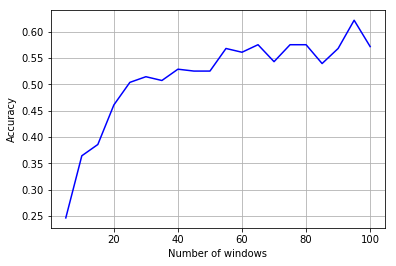

In [69]:
pylab.grid(True)
pylab.plot(n_windows, metrics, 'b-')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')

In [72]:
x, y = arrays_for_plot(feature_set_n=1, rate=1000)

Epoch 1/150
1400/1400 [==============================] - 2s 1ms/step - loss: 1.9528 - acc: 0.1407
Epoch 2/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.9469 - acc: 0.1450
Epoch 3/150
1400/1400 [==============================] - 0s 65us/step - loss: 1.9477 - acc: 0.1571
Epoch 4/150
1400/1400 [==============================] - 0s 61us/step - loss: 1.9458 - acc: 0.1514
Epoch 5/150
1400/1400 [==============================] - 0s 62us/step - loss: 1.9435 - acc: 0.1450
Epoch 6/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.9428 - acc: 0.1507
Epoch 7/150
1400/1400 [==============================] - 0s 74us/step - loss: 1.9444 - acc: 0.1643
Epoch 8/150
1400/1400 [==============================] - 0s 62us/step - loss: 1.9429 - acc: 0.1536
Epoch 9/150
1400/1400 [==============================] - 0s 68us/step - loss: 1.9414 - acc: 0.1550
Epoch 10/150
1400/1400 [==============================] - 0s 59us/step - loss: 1.9398 - acc: 0.1736
Epoch 11/1

1400/1400 [==============================] - 0s 61us/step - loss: 1.8560 - acc: 0.2543
Epoch 83/150
1400/1400 [==============================] - 0s 82us/step - loss: 1.8537 - acc: 0.2521
Epoch 84/150
1400/1400 [==============================] - 0s 70us/step - loss: 1.8486 - acc: 0.2714
Epoch 85/150
1400/1400 [==============================] - 0s 71us/step - loss: 1.8502 - acc: 0.2543
Epoch 86/150
1400/1400 [==============================] - 0s 66us/step - loss: 1.8415 - acc: 0.2736
Epoch 87/150
1400/1400 [==============================] - 0s 69us/step - loss: 1.8435 - acc: 0.2600
Epoch 88/150
1400/1400 [==============================] - 0s 57us/step - loss: 1.8456 - acc: 0.2614
Epoch 89/150
1400/1400 [==============================] - 0s 64us/step - loss: 1.8359 - acc: 0.2800
Epoch 90/150
1400/1400 [==============================] - 0s 58us/step - loss: 1.8380 - acc: 0.2679
Epoch 91/150
1400/1400 [==============================] - 0s 59us/step - loss: 1.8327 - acc: 0.2736
Epoch 92/150


1400/1400 [==============================] - 0s 82us/step - loss: 1.9292 - acc: 0.2021
Epoch 13/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.9305 - acc: 0.1921
Epoch 14/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.9258 - acc: 0.2143
Epoch 15/150
1400/1400 [==============================] - 0s 82us/step - loss: 1.9238 - acc: 0.2050
Epoch 16/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.9198 - acc: 0.1943
Epoch 17/150
1400/1400 [==============================] - 0s 78us/step - loss: 1.9220 - acc: 0.1943
Epoch 18/150
1400/1400 [==============================] - 0s 74us/step - loss: 1.9229 - acc: 0.2021
Epoch 19/150
1400/1400 [==============================] - 0s 75us/step - loss: 1.9210 - acc: 0.2014
Epoch 20/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.9168 - acc: 0.2107
Epoch 21/150
1400/1400 [==============================] - 0s 87us/step - loss: 1.9169 - acc: 0.2157
Epoch 22/150

1400/1400 [==============================] - 0s 73us/step - loss: 1.6919 - acc: 0.3271
Epoch 94/150
1400/1400 [==============================] - 0s 98us/step - loss: 1.6764 - acc: 0.3521
Epoch 95/150
1400/1400 [==============================] - 0s 90us/step - loss: 1.6812 - acc: 0.3393
Epoch 96/150
1400/1400 [==============================] - 0s 88us/step - loss: 1.6771 - acc: 0.3286
Epoch 97/150
1400/1400 [==============================] - 0s 90us/step - loss: 1.6614 - acc: 0.3371
Epoch 98/150
1400/1400 [==============================] - 0s 72us/step - loss: 1.6473 - acc: 0.3429
Epoch 99/150
1400/1400 [==============================] - 0s 85us/step - loss: 1.6595 - acc: 0.3407
Epoch 100/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.6625 - acc: 0.3407
Epoch 101/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.6479 - acc: 0.3336
Epoch 102/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.6530 - acc: 0.3571
Epoch 103/

1400/1400 [==============================] - 0s 85us/step - loss: 1.9336 - acc: 0.1857
Epoch 25/150
1400/1400 [==============================] - 0s 97us/step - loss: 1.9331 - acc: 0.1986
Epoch 26/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.9302 - acc: 0.1986
Epoch 27/150
1400/1400 [==============================] - 0s 106us/step - loss: 1.9290 - acc: 0.1964
Epoch 28/150
1400/1400 [==============================] - 0s 119us/step - loss: 1.9282 - acc: 0.1971
Epoch 29/150
1400/1400 [==============================] - 0s 102us/step - loss: 1.9292 - acc: 0.1971
Epoch 30/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.9289 - acc: 0.1900
Epoch 31/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.9244 - acc: 0.2093
Epoch 32/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.9247 - acc: 0.1986
Epoch 33/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.9227 - acc: 0.1986
Epoch 34

1400/1400 [==============================] - 0s 105us/step - loss: 1.7218 - acc: 0.3264
Epoch 106/150
1400/1400 [==============================] - 0s 151us/step - loss: 1.7033 - acc: 0.3464
Epoch 107/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.7037 - acc: 0.3336
Epoch 108/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.7103 - acc: 0.3207
Epoch 109/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.6879 - acc: 0.3507
Epoch 110/150
1400/1400 [==============================] - 0s 97us/step - loss: 1.6890 - acc: 0.3343
Epoch 111/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.6811 - acc: 0.3421
Epoch 112/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.6877 - acc: 0.3357
Epoch 113/150
1400/1400 [==============================] - 0s 93us/step - loss: 1.6811 - acc: 0.3371
Epoch 114/150
1400/1400 [==============================] - 0s 91us/step - loss: 1.6670 - acc: 0.3521

1400/1400 [==============================] - 0s 117us/step - loss: 1.8070 - acc: 0.2857
Epoch 36/150
1400/1400 [==============================] - 0s 92us/step - loss: 1.8107 - acc: 0.2707
Epoch 37/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.8012 - acc: 0.2914
Epoch 38/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.7895 - acc: 0.3021
Epoch 39/150
1400/1400 [==============================] - 0s 103us/step - loss: 1.7769 - acc: 0.3057
Epoch 40/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.7946 - acc: 0.2929
Epoch 41/150
1400/1400 [==============================] - 0s 112us/step - loss: 1.7844 - acc: 0.3157
Epoch 42/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.7702 - acc: 0.3236
Epoch 43/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.7671 - acc: 0.3100
Epoch 44/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.7677 - acc: 0.3100
Epoc

1400/1400 [==============================] - 0s 86us/step - loss: 1.4023 - acc: 0.4507
Epoch 116/150
1400/1400 [==============================] - 0s 86us/step - loss: 1.4115 - acc: 0.4650
Epoch 117/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.3791 - acc: 0.4779
Epoch 118/150
1400/1400 [==============================] - 0s 90us/step - loss: 1.4137 - acc: 0.4536
Epoch 119/150
1400/1400 [==============================] - 0s 93us/step - loss: 1.3963 - acc: 0.4664
Epoch 120/150
1400/1400 [==============================] - 0s 89us/step - loss: 1.3977 - acc: 0.4514
Epoch 121/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.3833 - acc: 0.4650
Epoch 122/150
1400/1400 [==============================] - 0s 95us/step - loss: 1.3901 - acc: 0.4679
Epoch 123/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.3691 - acc: 0.4871
Epoch 124/150
1400/1400 [==============================] - 0s 104us/step - loss: 1.3772 - acc: 0.4764
Ep

1400/1400 [==============================] - 0s 120us/step - loss: 1.7945 - acc: 0.2829
Epoch 46/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.7884 - acc: 0.2964
Epoch 47/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.7831 - acc: 0.2993
Epoch 48/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.7847 - acc: 0.2914
Epoch 49/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.7680 - acc: 0.3057
Epoch 50/150
1400/1400 [==============================] - 0s 112us/step - loss: 1.7684 - acc: 0.3043
Epoch 51/150
1400/1400 [==============================] - 0s 114us/step - loss: 1.7462 - acc: 0.3071
Epoch 52/150
1400/1400 [==============================] - 0s 96us/step - loss: 1.7403 - acc: 0.3236
Epoch 53/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.7410 - acc: 0.3179
Epoch 54/150
1400/1400 [==============================] - 0s 116us/step - loss: 1.7328 - acc: 0.3350
Epoc

1400/1400 [==============================] - 0s 125us/step - loss: 1.2152 - acc: 0.5693
Epoch 127/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.2197 - acc: 0.5436
Epoch 128/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.2317 - acc: 0.5464
Epoch 129/150
1400/1400 [==============================] - 0s 100us/step - loss: 1.2053 - acc: 0.5629
Epoch 130/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.1952 - acc: 0.5657
Epoch 131/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.1879 - acc: 0.5700
Epoch 132/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.1807 - acc: 0.5729
Epoch 133/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.1853 - acc: 0.5650
Epoch 134/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.1837 - acc: 0.5614
Epoch 135/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.1621 - acc: 0

1400/1400 [==============================] - 0s 102us/step - loss: 1.5815 - acc: 0.3679
Epoch 57/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5675 - acc: 0.3936
Epoch 58/150
1400/1400 [==============================] - 0s 108us/step - loss: 1.5706 - acc: 0.3843
Epoch 59/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5498 - acc: 0.3907
Epoch 60/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.5469 - acc: 0.3929
Epoch 61/150
1400/1400 [==============================] - 0s 105us/step - loss: 1.5372 - acc: 0.3936
Epoch 62/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.5437 - acc: 0.3929
Epoch 63/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5358 - acc: 0.4014
Epoch 64/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5114 - acc: 0.4236
Epoch 65/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.5114 - acc: 0.4157
Epo

1400/1400 [==============================] - 0s 101us/step - loss: 1.0754 - acc: 0.5907
Epoch 137/150
1400/1400 [==============================] - 0s 127us/step - loss: 1.0635 - acc: 0.6129
Epoch 138/150
1400/1400 [==============================] - 0s 114us/step - loss: 1.0377 - acc: 0.6143
Epoch 139/150
1400/1400 [==============================] - 0s 107us/step - loss: 1.0260 - acc: 0.6257
Epoch 140/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.0589 - acc: 0.5936
Epoch 141/150
1400/1400 [==============================] - 0s 101us/step - loss: 1.0601 - acc: 0.5993
Epoch 142/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.0598 - acc: 0.5921
Epoch 143/150
1400/1400 [==============================] - 0s 109us/step - loss: 1.0223 - acc: 0.6107
Epoch 144/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.0253 - acc: 0.6021
Epoch 145/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.0494 - acc: 0

1400/1400 [==============================] - 0s 115us/step - loss: 1.5224 - acc: 0.4093
Epoch 67/150
1400/1400 [==============================] - 0s 114us/step - loss: 1.5292 - acc: 0.3929
Epoch 68/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.5080 - acc: 0.3993
Epoch 69/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.5136 - acc: 0.4050
Epoch 70/150
1400/1400 [==============================] - 0s 111us/step - loss: 1.5059 - acc: 0.4064
Epoch 71/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.5067 - acc: 0.4021
Epoch 72/150
1400/1400 [==============================] - 0s 112us/step - loss: 1.4706 - acc: 0.4114
Epoch 73/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.4731 - acc: 0.4086
Epoch 74/150
1400/1400 [==============================] - 0s 113us/step - loss: 1.4732 - acc: 0.4221
Epoch 75/150
1400/1400 [==============================] - 0s 117us/step - loss: 1.4687 - acc: 0.4150
Epo

1400/1400 [==============================] - 0s 101us/step - loss: 1.0718 - acc: 0.5921
Epoch 147/150
1400/1400 [==============================] - 0s 121us/step - loss: 1.0795 - acc: 0.5950
Epoch 148/150
1400/1400 [==============================] - 0s 110us/step - loss: 1.0753 - acc: 0.5857
Epoch 149/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.0598 - acc: 0.6114
Epoch 150/150
280/280 [==============================] - 1s 2ms/step
Epoch 1/150
1400/1400 [==============================] - 2s 2ms/step - loss: 1.9493 - acc: 0.1500
Epoch 2/150
1400/1400 [==============================] - 0s 150us/step - loss: 1.9456 - acc: 0.1550
Epoch 3/150
1400/1400 [==============================] - 0s 153us/step - loss: 1.9430 - acc: 0.1671
Epoch 4/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.9407 - acc: 0.1886
Epoch 5/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.9352 - acc: 0.1829
Epoch 6/150
1400/1400 [================

1400/1400 [==============================] - 0s 124us/step - loss: 1.4162 - acc: 0.4500
Epoch 77/150
1400/1400 [==============================] - 0s 137us/step - loss: 1.3992 - acc: 0.4693
Epoch 78/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.4030 - acc: 0.4629
Epoch 79/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.3972 - acc: 0.4429
Epoch 80/150
1400/1400 [==============================] - 0s 141us/step - loss: 1.3975 - acc: 0.4507 0s - loss: 1.4041 - acc: 0.446
Epoch 81/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.3945 - acc: 0.4543
Epoch 82/150
1400/1400 [==============================] - 0s 135us/step - loss: 1.3791 - acc: 0.4629
Epoch 83/150
1400/1400 [==============================] - 0s 146us/step - loss: 1.3761 - acc: 0.4650
Epoch 84/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.3648 - acc: 0.4621
Epoch 85/150
1400/1400 [==============================] - 0s 121us/step -

Epoch 6/150
1400/1400 [==============================] - 0s 138us/step - loss: 1.9363 - acc: 0.1821
Epoch 7/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.9305 - acc: 0.2057
Epoch 8/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.9290 - acc: 0.2043
Epoch 9/150
1400/1400 [==============================] - 0s 127us/step - loss: 1.9275 - acc: 0.1929
Epoch 10/150
1400/1400 [==============================] - 0s 122us/step - loss: 1.9246 - acc: 0.2029
Epoch 11/150
1400/1400 [==============================] - 0s 134us/step - loss: 1.9171 - acc: 0.2250
Epoch 12/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.9242 - acc: 0.2014
Epoch 13/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.9105 - acc: 0.2243
Epoch 14/150
1400/1400 [==============================] - 0s 118us/step - loss: 1.9060 - acc: 0.2471
Epoch 15/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.9040 - acc: 0

Epoch 87/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.2910 - acc: 0.5121
Epoch 88/150
1400/1400 [==============================] - 0s 126us/step - loss: 1.2712 - acc: 0.5121
Epoch 89/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.2787 - acc: 0.5114
Epoch 90/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.2608 - acc: 0.5200
Epoch 91/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.2408 - acc: 0.5264
Epoch 92/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.2397 - acc: 0.5200
Epoch 93/150
1400/1400 [==============================] - 0s 129us/step - loss: 1.2259 - acc: 0.5214
Epoch 94/150
1400/1400 [==============================] - 0s 160us/step - loss: 1.2251 - acc: 0.5450
Epoch 95/150
1400/1400 [==============================] - 0s 147us/step - loss: 1.2253 - acc: 0.5564
Epoch 96/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.2144 - ac

1400/1400 [==============================] - 0s 130us/step - loss: 1.8532 - acc: 0.2600
Epoch 17/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.8419 - acc: 0.2857
Epoch 18/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.8381 - acc: 0.2650
Epoch 19/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.8195 - acc: 0.2736
Epoch 20/150
1400/1400 [==============================] - 0s 124us/step - loss: 1.8102 - acc: 0.2843
Epoch 21/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.8024 - acc: 0.2864
Epoch 22/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.7947 - acc: 0.2850
Epoch 23/150
1400/1400 [==============================] - 0s 128us/step - loss: 1.7813 - acc: 0.3007
Epoch 24/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.7724 - acc: 0.3064
Epoch 25/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.7607 - acc: 0.3071
Epo

1400/1400 [==============================] - 0s 130us/step - loss: 1.2032 - acc: 0.5421
Epoch 98/150
1400/1400 [==============================] - 0s 133us/step - loss: 1.2047 - acc: 0.5357
Epoch 99/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.1923 - acc: 0.5586
Epoch 100/150
1400/1400 [==============================] - 0s 130us/step - loss: 1.1848 - acc: 0.5543
Epoch 101/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.1798 - acc: 0.5464
Epoch 102/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.1758 - acc: 0.5493
Epoch 103/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.1802 - acc: 0.5393
Epoch 104/150
1400/1400 [==============================] - 0s 125us/step - loss: 1.1620 - acc: 0.5514
Epoch 105/150
1400/1400 [==============================] - 0s 132us/step - loss: 1.1749 - acc: 0.5657
Epoch 106/150
1400/1400 [==============================] - 0s 131us/step - loss: 1.1869 - acc: 0.5

1400/1400 [==============================] - 0s 162us/step - loss: 1.6525 - acc: 0.3207
Epoch 28/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.6271 - acc: 0.3429
Epoch 29/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.6270 - acc: 0.3457
Epoch 30/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.6190 - acc: 0.3307
Epoch 31/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.5970 - acc: 0.3607
Epoch 32/150
1400/1400 [==============================] - 0s 157us/step - loss: 1.5934 - acc: 0.3536
Epoch 33/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.5801 - acc: 0.3693
Epoch 34/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5823 - acc: 0.3436
Epoch 35/150
1400/1400 [==============================] - 0s 159us/step - loss: 1.5458 - acc: 0.3729
Epoch 36/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.5367 - acc: 0.3893
Epo

1400/1400 [==============================] - 0s 149us/step - loss: 0.9391 - acc: 0.6600
Epoch 109/150
1400/1400 [==============================] - 0s 175us/step - loss: 0.9199 - acc: 0.6686
Epoch 110/150
1400/1400 [==============================] - 0s 179us/step - loss: 0.9055 - acc: 0.6721
Epoch 111/150
1400/1400 [==============================] - 0s 159us/step - loss: 0.9632 - acc: 0.6500
Epoch 112/150
1400/1400 [==============================] - 0s 188us/step - loss: 0.9019 - acc: 0.6829
Epoch 113/150
1400/1400 [==============================] - 0s 154us/step - loss: 0.9206 - acc: 0.6671
Epoch 114/150
1400/1400 [==============================] - 0s 195us/step - loss: 0.8951 - acc: 0.6714
Epoch 115/150
1400/1400 [==============================] - 0s 169us/step - loss: 0.9225 - acc: 0.6657
Epoch 116/150
1400/1400 [==============================] - 0s 165us/step - loss: 0.8772 - acc: 0.6764
Epoch 117/150
1400/1400 [==============================] - 0s 193us/step - loss: 0.8641 - acc: 0

1400/1400 [==============================] - 0s 169us/step - loss: 1.7325 - acc: 0.3143
Epoch 39/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.7218 - acc: 0.3107
Epoch 40/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.7230 - acc: 0.3200
Epoch 41/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.7184 - acc: 0.3014
Epoch 42/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.7064 - acc: 0.3107
Epoch 43/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.7030 - acc: 0.3121
Epoch 44/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.6955 - acc: 0.3279
Epoch 45/150
1400/1400 [==============================] - 0s 163us/step - loss: 1.6847 - acc: 0.3129
Epoch 46/150
1400/1400 [==============================] - 0s 155us/step - loss: 1.6861 - acc: 0.3143
Epoch 47/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.6839 - acc: 0.3107
Epo

1400/1400 [==============================] - 0s 164us/step - loss: 1.2468 - acc: 0.5014
Epoch 119/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.2258 - acc: 0.5150
Epoch 120/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.1973 - acc: 0.5243
Epoch 121/150
1400/1400 [==============================] - 0s 162us/step - loss: 1.2181 - acc: 0.5086
Epoch 122/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.2116 - acc: 0.5143
Epoch 123/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.2009 - acc: 0.5386
Epoch 124/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.2211 - acc: 0.5093
Epoch 125/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.1917 - acc: 0.5393
Epoch 126/150
1400/1400 [==============================] - 0s 170us/step - loss: 1.1976 - acc: 0.5307
Epoch 127/150
1400/1400 [==============================] - 0s 165us/step - loss: 1.1800 - acc: 0

1400/1400 [==============================] - 0s 172us/step - loss: 1.6518 - acc: 0.3593
Epoch 49/150
1400/1400 [==============================] - 0s 166us/step - loss: 1.6249 - acc: 0.3686
Epoch 50/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.6345 - acc: 0.3614
Epoch 51/150
1400/1400 [==============================] - 0s 172us/step - loss: 1.6241 - acc: 0.3671
Epoch 52/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.6049 - acc: 0.3807
Epoch 53/150
1400/1400 [==============================] - 0s 174us/step - loss: 1.5989 - acc: 0.3714
Epoch 54/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.5896 - acc: 0.3843
Epoch 55/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.5894 - acc: 0.3914
Epoch 56/150
1400/1400 [==============================] - 0s 194us/step - loss: 1.5724 - acc: 0.3836
Epoch 57/150
1400/1400 [==============================] - 0s 168us/step - loss: 1.5764 - acc: 0.3950
Epo

Epoch 129/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.0404 - acc: 0.6064
Epoch 130/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.0351 - acc: 0.6136
Epoch 131/150
1400/1400 [==============================] - 0s 169us/step - loss: 1.0213 - acc: 0.6157
Epoch 132/150
1400/1400 [==============================] - 0s 181us/step - loss: 0.9988 - acc: 0.6350
Epoch 133/150
1400/1400 [==============================] - 0s 161us/step - loss: 1.0084 - acc: 0.6236
Epoch 134/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.0088 - acc: 0.6064
Epoch 135/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.0329 - acc: 0.6157
Epoch 136/150
1400/1400 [==============================] - 0s 155us/step - loss: 0.9944 - acc: 0.6243
Epoch 137/150
1400/1400 [==============================] - 0s 167us/step - loss: 0.9561 - acc: 0.6464
Epoch 138/150
1400/1400 [==============================] - 0s 153us/step - loss: 0

1400/1400 [==============================] - 0s 184us/step - loss: 1.4247 - acc: 0.4550
Epoch 60/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.4465 - acc: 0.4429
Epoch 61/150
1400/1400 [==============================] - 0s 190us/step - loss: 1.4238 - acc: 0.4443
Epoch 62/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.4036 - acc: 0.4679
Epoch 63/150
1400/1400 [==============================] - 0s 181us/step - loss: 1.4132 - acc: 0.4507
Epoch 64/150
1400/1400 [==============================] - 0s 182us/step - loss: 1.3929 - acc: 0.4664
Epoch 65/150
1400/1400 [==============================] - 0s 186us/step - loss: 1.3955 - acc: 0.4693
Epoch 66/150
1400/1400 [==============================] - 0s 184us/step - loss: 1.3661 - acc: 0.4964
Epoch 67/150
1400/1400 [==============================] - 0s 179us/step - loss: 1.3816 - acc: 0.4721
Epoch 68/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.3486 - acc: 0.4943
Epo

1400/1400 [==============================] - 0s 180us/step - loss: 0.7720 - acc: 0.7179
Epoch 140/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.7702 - acc: 0.7136
Epoch 141/150
1400/1400 [==============================] - 0s 174us/step - loss: 0.7799 - acc: 0.7064
Epoch 142/150
1400/1400 [==============================] - 0s 182us/step - loss: 0.7666 - acc: 0.7236
Epoch 143/150
1400/1400 [==============================] - 0s 180us/step - loss: 0.7782 - acc: 0.7143
Epoch 144/150
1400/1400 [==============================] - ETA: 0s - loss: 0.7467 - acc: 0.730 - 0s 189us/step - loss: 0.7543 - acc: 0.7236
Epoch 145/150
1400/1400 [==============================] - 0s 179us/step - loss: 0.7625 - acc: 0.7207
Epoch 146/150
1400/1400 [==============================] - 0s 180us/step - loss: 0.7638 - acc: 0.7150
Epoch 147/150
1400/1400 [==============================] - 0s 177us/step - loss: 0.7546 - acc: 0.7143
Epoch 148/150
1400/1400 [==============================] -

1400/1400 [==============================] - 0s 182us/step - loss: 1.1977 - acc: 0.5443
Epoch 70/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.1626 - acc: 0.5657
Epoch 71/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.1696 - acc: 0.5650
Epoch 72/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.1524 - acc: 0.5550
Epoch 73/150
1400/1400 [==============================] - 0s 171us/step - loss: 1.1418 - acc: 0.5671
Epoch 74/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.1581 - acc: 0.5664
Epoch 75/150
1400/1400 [==============================] - 0s 178us/step - loss: 1.1280 - acc: 0.5886
Epoch 76/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.1324 - acc: 0.5943
Epoch 77/150
1400/1400 [==============================] - 0s 175us/step - loss: 1.1241 - acc: 0.5771
Epoch 78/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.1122 - acc: 0.5800
Epo

1400/1400 [==============================] - 0s 162us/step - loss: 0.5858 - acc: 0.7879
Epoch 150/150
280/280 [==============================] - 1s 3ms/step
Epoch 1/150
1400/1400 [==============================] - 2s 2ms/step - loss: 1.9607 - acc: 0.1493
Epoch 2/150
1400/1400 [==============================] - 0s 177us/step - loss: 1.9471 - acc: 0.1464
Epoch 3/150
1400/1400 [==============================] - 0s 192us/step - loss: 1.9424 - acc: 0.1521
Epoch 4/150
1400/1400 [==============================] - 0s 195us/step - loss: 1.9364 - acc: 0.1629
Epoch 5/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.9314 - acc: 0.1893
Epoch 6/150
1400/1400 [==============================] - 0s 185us/step - loss: 1.9230 - acc: 0.2007
Epoch 7/150
1400/1400 [==============================] - 0s 187us/step - loss: 1.9149 - acc: 0.2014
Epoch 8/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.9034 - acc: 0.2136
Epoch 9/150
1400/1400 [======================

1400/1400 [==============================] - 0s 185us/step - loss: 1.1771 - acc: 0.5571
Epoch 80/150
1400/1400 [==============================] - 0s 216us/step - loss: 1.1873 - acc: 0.5550
Epoch 81/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.1681 - acc: 0.5700
Epoch 82/150
1400/1400 [==============================] - 0s 183us/step - loss: 1.1493 - acc: 0.5571
Epoch 83/150
1400/1400 [==============================] - 0s 180us/step - loss: 1.1388 - acc: 0.5757
Epoch 84/150
1400/1400 [==============================] - 0s 191us/step - loss: 1.1283 - acc: 0.5814 0s - loss: 1.1837 - acc: 0.5
Epoch 85/150
1400/1400 [==============================] - 0s 176us/step - loss: 1.1610 - acc: 0.5586
Epoch 86/150
1400/1400 [==============================] - 0s 173us/step - loss: 1.1206 - acc: 0.5850
Epoch 87/150
1400/1400 [==============================] - 0s 200us/step - loss: 1.1264 - acc: 0.5821
Epoch 88/150
1400/1400 [==============================] - 0s 166us/step - l

1400/1400 [==============================] - 0s 215us/step - loss: 1.9305 - acc: 0.1779
Epoch 9/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.9268 - acc: 0.1886
Epoch 10/150
1400/1400 [==============================] - 0s 164us/step - loss: 1.9212 - acc: 0.2036
Epoch 11/150
1400/1400 [==============================] - 0s 233us/step - loss: 1.9188 - acc: 0.1907
Epoch 12/150
1400/1400 [==============================] - 0s 198us/step - loss: 1.9136 - acc: 0.2007
Epoch 13/150
1400/1400 [==============================] - 0s 262us/step - loss: 1.9094 - acc: 0.2036
Epoch 14/150
1400/1400 [==============================] - 0s 237us/step - loss: 1.9033 - acc: 0.2029
Epoch 15/150
1400/1400 [==============================] - 0s 232us/step - loss: 1.8985 - acc: 0.2093
Epoch 16/150
1400/1400 [==============================] - 0s 246us/step - loss: 1.8961 - acc: 0.2107
Epoch 17/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.8870 - acc: 0.2114
Epoc

1400/1400 [==============================] - 0s 220us/step - loss: 1.2874 - acc: 0.5050
Epoch 90/150
1400/1400 [==============================] - 0s 219us/step - loss: 1.2549 - acc: 0.5193
Epoch 91/150
1400/1400 [==============================] - 0s 212us/step - loss: 1.2595 - acc: 0.5043
Epoch 92/150
1400/1400 [==============================] - 0s 230us/step - loss: 1.2749 - acc: 0.4929
Epoch 93/150
1400/1400 [==============================] - 0s 199us/step - loss: 1.2658 - acc: 0.4807
Epoch 94/150
1400/1400 [==============================] - 0s 193us/step - loss: 1.2487 - acc: 0.5071
Epoch 95/150
1400/1400 [==============================] - 0s 203us/step - loss: 1.2264 - acc: 0.5186
Epoch 96/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.2298 - acc: 0.5136
Epoch 97/150
1400/1400 [==============================] - 0s 210us/step - loss: 1.2356 - acc: 0.5150
Epoch 98/150
1400/1400 [==============================] - 0s 215us/step - loss: 1.2453 - acc: 0.5200
Epo

1400/1400 [==============================] - 0s 235us/step - loss: 1.7440 - acc: 0.2936
Epoch 20/150
1400/1400 [==============================] - 0s 238us/step - loss: 1.7293 - acc: 0.3107
Epoch 21/150
1400/1400 [==============================] - 0s 212us/step - loss: 1.7122 - acc: 0.3236
Epoch 22/150
1400/1400 [==============================] - 0s 206us/step - loss: 1.6997 - acc: 0.3164
Epoch 23/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.7033 - acc: 0.2964
Epoch 24/150
1400/1400 [==============================] - 0s 201us/step - loss: 1.6737 - acc: 0.3321
Epoch 25/150
1400/1400 [==============================] - 0s 217us/step - loss: 1.6727 - acc: 0.3121
Epoch 26/150
1400/1400 [==============================] - 0s 221us/step - loss: 1.6493 - acc: 0.3193
Epoch 27/150
1400/1400 [==============================] - 0s 274us/step - loss: 1.6536 - acc: 0.3400
Epoch 28/150
1400/1400 [==============================] - 0s 246us/step - loss: 1.6278 - acc: 0.3600
Epo

1400/1400 [==============================] - 0s 203us/step - loss: 1.0306 - acc: 0.6300
Epoch 101/150
1400/1400 [==============================] - 0s 235us/step - loss: 1.0050 - acc: 0.6336
Epoch 102/150
1400/1400 [==============================] - 0s 273us/step - loss: 0.9859 - acc: 0.6357
Epoch 103/150
1400/1400 [==============================] - 0s 211us/step - loss: 0.9627 - acc: 0.6336
Epoch 104/150
1400/1400 [==============================] - 0s 216us/step - loss: 0.9732 - acc: 0.6479
Epoch 105/150
1400/1400 [==============================] - 0s 202us/step - loss: 0.9638 - acc: 0.6321 0s - loss: 0.9636 - acc: 0.63
Epoch 106/150
1400/1400 [==============================] - 0s 221us/step - loss: 0.9448 - acc: 0.6636
Epoch 107/150
1400/1400 [==============================] - 0s 215us/step - loss: 0.9392 - acc: 0.6536
Epoch 108/150
1400/1400 [==============================] - 0s 211us/step - loss: 0.9295 - acc: 0.6300
Epoch 109/150
1400/1400 [==============================] - 0s 218u

1400/1400 [==============================] - 0s 223us/step - loss: 1.7958 - acc: 0.3200
Epoch 30/150
1400/1400 [==============================] - 0s 197us/step - loss: 1.7904 - acc: 0.3143
Epoch 31/150
1400/1400 [==============================] - 0s 218us/step - loss: 1.7874 - acc: 0.3107
Epoch 32/150
1400/1400 [==============================] - 0s 221us/step - loss: 1.7831 - acc: 0.2986
Epoch 33/150
1400/1400 [==============================] - 0s 208us/step - loss: 1.7662 - acc: 0.3279
Epoch 34/150
1400/1400 [==============================] - 0s 210us/step - loss: 1.7553 - acc: 0.3343
Epoch 35/150
1400/1400 [==============================] - 0s 207us/step - loss: 1.7374 - acc: 0.3600
Epoch 36/150
1400/1400 [==============================] - 0s 213us/step - loss: 1.7319 - acc: 0.3264
Epoch 37/150
1400/1400 [==============================] - 0s 206us/step - loss: 1.7270 - acc: 0.3350
Epoch 38/150
1400/1400 [==============================] - 0s 208us/step - loss: 1.7103 - acc: 0.3514
Epo

1400/1400 [==============================] - 0s 208us/step - loss: 0.9168 - acc: 0.6729
Epoch 111/150
1400/1400 [==============================] - 0s 207us/step - loss: 0.9397 - acc: 0.6643
Epoch 112/150
1400/1400 [==============================] - 0s 214us/step - loss: 0.8841 - acc: 0.6793
Epoch 113/150
1400/1400 [==============================] - 0s 213us/step - loss: 0.9074 - acc: 0.6700
Epoch 114/150
1400/1400 [==============================] - 0s 213us/step - loss: 0.8984 - acc: 0.6743
Epoch 115/150
1400/1400 [==============================] - 0s 219us/step - loss: 0.8975 - acc: 0.6714
Epoch 116/150
1400/1400 [==============================] - 0s 213us/step - loss: 0.8660 - acc: 0.6850
Epoch 117/150
1400/1400 [==============================] - 0s 201us/step - loss: 0.8504 - acc: 0.6964
Epoch 118/150
1400/1400 [==============================] - 0s 215us/step - loss: 0.8619 - acc: 0.6986
Epoch 119/150
1400/1400 [==============================] - 0s 217us/step - loss: 0.8187 - acc: 0

1400/1400 [==============================] - 0s 278us/step - loss: 1.4636 - acc: 0.4386
Epoch 41/150
1400/1400 [==============================] - 0s 297us/step - loss: 1.4487 - acc: 0.4593
Epoch 42/150
1400/1400 [==============================] - 0s 271us/step - loss: 1.4170 - acc: 0.4750
Epoch 43/150
1400/1400 [==============================] - 0s 241us/step - loss: 1.4345 - acc: 0.4643
Epoch 44/150
1400/1400 [==============================] - 0s 230us/step - loss: 1.3996 - acc: 0.4736
Epoch 45/150
1400/1400 [==============================] - 0s 226us/step - loss: 1.3769 - acc: 0.4779
Epoch 46/150
1400/1400 [==============================] - 0s 233us/step - loss: 1.3904 - acc: 0.4793
Epoch 47/150
1400/1400 [==============================] - 0s 240us/step - loss: 1.3600 - acc: 0.4964
Epoch 48/150
1400/1400 [==============================] - 0s 228us/step - loss: 1.3644 - acc: 0.4643
Epoch 49/150
1400/1400 [==============================] - 0s 229us/step - loss: 1.3283 - acc: 0.5136
Epo

1400/1400 [==============================] - 0s 214us/step - loss: 0.6269 - acc: 0.7693
Epoch 121/150
1400/1400 [==============================] - 0s 228us/step - loss: 0.5552 - acc: 0.8136
Epoch 122/150
1400/1400 [==============================] - 0s 227us/step - loss: 0.6014 - acc: 0.7771
Epoch 123/150
1400/1400 [==============================] - 0s 224us/step - loss: 0.5387 - acc: 0.8157
Epoch 124/150
1400/1400 [==============================] - 0s 222us/step - loss: 0.5797 - acc: 0.8043
Epoch 125/150
1400/1400 [==============================] - 0s 214us/step - loss: 0.5475 - acc: 0.8121
Epoch 126/150
1400/1400 [==============================] - 0s 221us/step - loss: 0.5472 - acc: 0.8214
Epoch 127/150
1400/1400 [==============================] - 0s 233us/step - loss: 0.5396 - acc: 0.8186
Epoch 128/150
1400/1400 [==============================] - 0s 233us/step - loss: 0.5377 - acc: 0.8271
Epoch 129/150
1400/1400 [==============================] - 0s 223us/step - loss: 0.5478 - acc: 0

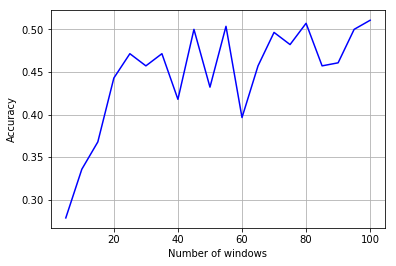

In [73]:
pylab.grid(True)
pylab.plot(x, y, 'b-')
pylab.ylabel('Accuracy')
pylab.xlabel('Number of windows')